In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import copy

In [3]:
# Class that holds a quantity which can be inflow, volume or outflow
class Quantity:
    
    def __init__(self, name=None, value=None, derivative=None):
        self.name = name
        
        if value == None:
            self.value = '0'
        else:
            self.value = value

        if derivative == None:
            self.derivative = '0'
        else:
            self.derivative = derivative
            
    def __repr__(self):
        string = '{}: ({}, {})'.format(self.name, self.value, self.derivative)
        if len(self.name) <= 6: 
            string = string[:6] + ' ' + string[6:]
            
        return string

    __str__ = __repr__

# Class that holds a state
class State:

    def __init__(self, inflow=None, volume=None, outflow=None):
        if inflow == None:
            self.inflow = Quantity(name='inflow')
        else:
            self.inflow = inflow
            
        if volume == None:
            self.volume = Quantity(name='volume')
        else:
            self.volume = volume
            
        if outflow == None:
            self.outflow = Quantity(name='outflow')
        else:
            self.outflow = outflow
        
    def __repr__(self):
        return  str(self.inflow) + '\n' + \
                str(self.volume) + '\n' + \
                str(self.outflow) + '\n'
        
    def description(self):
        quantities = [self.inflow, self.volume, self.outflow]
        
        for quantity in quantities:
            
            if quantity.value == '0':
                value = 'no'
            elif quantity.value == '+':
                value = 'some'
            elif quantity.value == 'max':
                value = 'a maximum amount of'
            
            if quantity.derivative == '0':
                derivative = 'remains the same'
            elif quantity.derivative == '+':
                derivative = 'is increasing'
            elif quantity.derivative == '-':
                derivative = 'is decreasing'
            
            print('There is {} {} and the {} {}.'.format(value, quantity.name, quantity.name, derivative))
            
    __str__ = __repr__

In [4]:
def get_children(node):
    children = []
    
    # Actions on the tap
    if node.inflow.derivative == '0': # If there is no current action performed on the tap
        child = copy.deepcopy(node)
        child.inflow.derivative = '0' # Ramains unchanged
        children.append(child)
        
        child = copy.deepcopy(node)
        child.inflow.derivative = '+' # Open the tap
        children.append(child)
        
        if node.inflow.value == '+':  # If there is some inflow
            child = copy.deepcopy(node)
            child.inflow.derivative = '-' # Turn off the tap
            children.append(child)

    if node.inflow.derivative == '+': # If the tap is being opened
        child = copy.deepcopy(node)
        child.inflow.derivative = '0' # Stop opening the tap
        children.append(child) 
        
        child = copy.deepcopy(node)
        child.inflow.derivative = '+' # Keep opening the tap even more
        children.append(child) 
    
    if node.inflow.derivative == '-': # If the tap is being closed
        child = copy.deepcopy(node)
        child.inflow.derivative = '0' # Stop closing the tap
        children.append(child) 
        
        if node.inflow.value == '+':  # If there is some inflow
            child = copy.deepcopy(node)
            child.inflow.derivative = '-' # Turn off the tap even more
            children.append(child)
    
    # Consequences of previous states
    # Inflow changes
    if node.inflow.derivative == '+': # If the tap was opened
        for child in children:
            child.inflow.value = '+' # There is some inflow
            child.volume.derivative = '+' # Volume is increasing
            child.outflow.derivative = '+' # Outflow is increasing
            
    elif node.inflow.derivative == '0': # If the tap remains untouched
        for child in children:
            child.volume.derivative = '0' # Volume remains the same
            child.outflow.derivative = '0' # Outflow remains the same
            
    elif node.inflow.derivative == '-': # If the tap was closing
        for child in children:
            child.inflow.value = '0' # Inflow becomes zero
            child.volume.derivative = '-' # Volume is decreasing
            child.outflow.derivative = '-' # Outflow is decreasing

    # Volume/outflow changes
    if node.volume.derivative == '+': # If the volume is increasing
        if node.volume.value == '0': # If there is no volume to begin with
            for child in children:
                child.volume.value = '+' # The is some volume
                child.outflow.value = '+' # The is some outflow
        elif child.volume.value == '+': # If there already was some volume
            for child in children:
                child.volume.value = 'max' # The volume becomes maximum
                child.outflow.value = 'max' # The outflow becomes maximum
                
    elif node.volume.derivative == '-': # If the volume is decreasing
        if node.volume.value == '+': # If there was some volume
            for child in children:
                child.volume.value = '0' # The is no volume
                child.outflow.value = '0' # The is no outflow          
        elif node.volume.value == 'max': # If the volume was maximum
            for child in children:
                child.volume.value = '+' # The is some volume
                child.outflow.value = '+' # The is some outflow         
    
    if node.inflow.value == '0': # If there is no inflow
        for child in children:
            if child.volume.value != '0': # If there is some volume (may be max)
                child.volume.derivative = '-' # The volume is decreasing
                child.outflow.derivative = '-' # The outflow is decreasing
                
    # Exceptions
    for child in children: 
        if child.volume.value == 'max' and child.volume.derivative == '+': # Tank is overflowing
            child.volume.derivative = '0' # Volume can't be increasing when at max
            child.outflow.derivative = '0' # Outflow can't be increasing when at max
            
        if child.inflow.value == '0' and child.inflow.derivative == '-': # Something that is not there can't decrease
            children.remove(child)

        if child.volume.value == '0' and child.volume.derivative == '-': # Something that is not there can't decrease
            children.remove(child)

        if repr(child) == repr(node): # Remove children that are similar to parent node
            children.remove(child)

    return children

---------------------
State 1
Current node:
inflow : (0, 0)
volume : (0, 0)
outflow: (0, 0)

There is no inflow and the inflow remains the same.
There is no volume and the volume remains the same.
There is no outflow and the outflow remains the same.
---------------------
State 2
Current node:
inflow : (0, +)
volume : (0, 0)
outflow: (0, 0)

There is no inflow and the inflow is increasing.
There is no volume and the volume remains the same.
There is no outflow and the outflow remains the same.
---------------------
State 3
Current node:
inflow : (+, 0)
volume : (0, +)
outflow: (0, +)

There is some inflow and the inflow remains the same.
There is no volume and the volume is increasing.
There is no outflow and the outflow is increasing.
---------------------
State 4
Current node:
inflow : (+, +)
volume : (0, +)
outflow: (0, +)

There is some inflow and the inflow is increasing.
There is no volume and the volume is increasing.
There is no outflow and the outflow is increasing.
----------

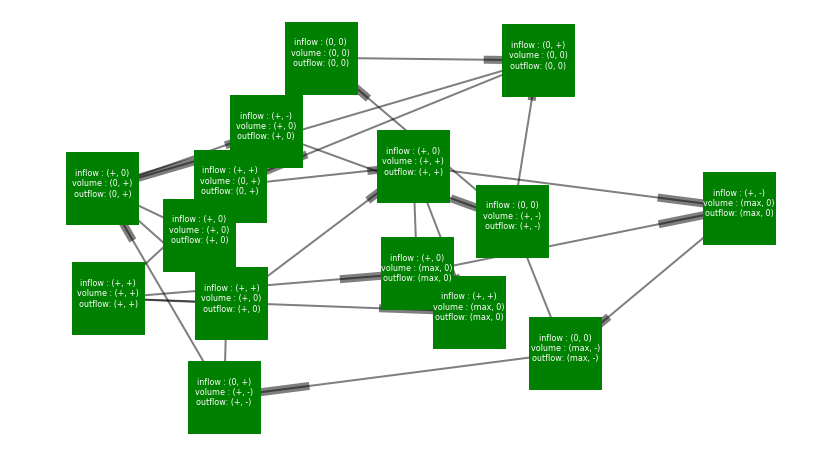

In [26]:
# The startnode is an empty tank with no inflow:
# inflow : (0, 0)
# volume : (0, 0)
# outflow: (0, 0)
startnode = State()

# The history is used to keep track of all the nodes we have seen before
history = [repr(startnode)]

# The stack keeps track of all the nodes we still have to explore
stack = [startnode]

G=nx.MultiDiGraph()
plt.figure(3,figsize=(14,8)) 
G.add_node(repr(startnode))

state_no = 0 # Counts the number of states

while len(stack) > 0 :
    
    print('---------------------')
    state_no += 1
    print('State', state_no)
    
    # Get the an unexplored node and generate its children.
    node = stack.pop(0)
    
    # Some trace prints
    print('Current node:\n' + str(node))
    node.description()
    
    for child in get_children(node):
        # Add the edge to the graph between these two nodes   
        G.add_edge(repr(node), repr(child))
        if repr(child) not in history: # If child not seen before or not yet in stack
            stack.append(child) # Put in stack
            G.add_node(repr(child))
            history.append(repr(child))

# Draw graph    
graph_pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G,graph_pos,node_size=5200,alpha=1,node_color='green', node_shape='s')
nx.draw_networkx_edges(G,graph_pos,alpha=0.5,width=2, arrows=True)
nx.draw_networkx_labels(G,graph_pos,font_size=8, font_family='sans-serif', font_color='white')

# Show graph
plt.axis('off')
plt.show()